In [1]:
from picamera.array import PiYUVArray, PiRGBArray
from picamera import PiCamera

from scipy.signal import find_peaks, butter, filtfilt

import time
import matplotlib.pyplot as plt
import skimage as ski
import numpy as np

# Camera resolution
res = (640, 480)

CAMERA_CENTER = res[0] // 2
       
from pwm import PWM

import PID

## Setup servo and motor PWM signal to control the steering angle and the speed.

The values specified period and duty cycle ar in nanoseconds.

Servo and motor controlled follow the following protocol:
  1. Control signal is read 50 times per second by each device (servo and speed controller). Thus period is 20 ms => 20000000 ns
  2. To send the minimum value (full left for servo and break for motor) the duty cycle should be 1 ms => 1000000 ns
  3. Maximum value corresponds to a duty cycle of 2 ms => 2000000 ns
  
However, these devices are not perfect and you can set a duty cycle outside this range and still get a response. I would recoment to play with it and find are the limits in your case. Pay attention that servo is limited by the mechanical construction how much it can turn the wheels. Do not set these limits to a value which servo cannot execute as it will try to do that and eventually burn.

In [2]:
# Enable servo
SERVO_MIDDLE = 1500000
SERVO_MAX = 2000000
SERVO_MIN = 1000000

servo = PWM(1)
servo.period = 20000000
servo.duty_cycle = SERVO_MIDDLE
servo.enable = True

In [3]:
# Enable servo
MOTOR_BRAKE = 1000000

motor = PWM(0)
motor.period = 20000000
motor.duty_cycle = MOTOR_BRAKE
motor.enable = True

In [4]:
motor.duty_cycle = MOTOR_BRAKE 

## The self driving code

Quick explanation on how this algorithm works:
  1. Initialize the camera, use a frame rate of 10 to 20 fps
  2. Get the coefficients of the butterworth filter of order 3 and cut-off frequency of 0.1 (change cut of frequency if the peak functions is not working)
  3. For each frame captured from the camera:
    1. Get the blak and white part of the image
    2. Select line 195 to use for lane detection (this number depends on your camera angle)
    3. Filter the line and find the peaks that are greater than 160. White parts of the image have higher values than the black. The threshold of 160 depends on the ambient light, lower if the room is darker
    4. Find the peaks left and right of the camera center, these peaks should corresponds to the white lines delimiting the track,
    5. Compute the center point between these lines. This is where we want our car
    6. Compute the error by substracting the center point from camera middle and multiply by 5000. 5000 is our P gain.
    7. Adjust the duty cycle of the servo such that the

In [8]:
# Run a track detection algorithm on a single horizontal line.
# Uses YUV420 image format as the Y component corresponds to image intensity (gray image)
# and thus there is no need to convert from RGB to BW

'''
Ku = 1000
Tu = 100

Kp = 0.6*Ku
Ki = 1.2*Ku/Tu
Kd = 3/40*Ku*Tu
'''

Kp = 5000
Ki = 100
Kd = 800

FRAMERATE = 15
OFFSET = -10
SPEED = 100000
SCAN_LINE = 190
PEAK_THRES = 150

CAMERA_CENTER = res[0] // 2 + OFFSET

RUN_TIMER = 60 # seconds
history=[]

camera = PiCamera()
        
# Check the link below for the combinations between mode and resolution
# https://picamera.readthedocs.io/en/release-1.13/fov.html#sensor-modes
camera.sensor_mode = 7
camera.resolution = res
camera.framerate = FRAMERATE

# Initialize the buffer and start capturing
rawCapture = PiYUVArray(camera, size=res)
stream = camera.capture_continuous(rawCapture, format="yuv", use_video_port=True)

# Measure the time needed to process 300 images to estimate the FPS
ti = t = time.time()

# To filter the noise in the image we use a 3rd order Butterworth filter

# Wn = 0.02, the cut-off frequency, acceptable values are from 0 to 1
b, a = butter(3, 0.1)

line_pos    = CAMERA_CENTER
first_frame = True

pid = PID.PID(Kp, Ki, Kd)
pid.SetPoint = CAMERA_CENTER
#pid.setSampleTime(1/camera.framerate)

pos_hist = []
# pid_hist = []
# duty_hist = []
# time_hist = []
frame_hist = []
# max_hist = []

# start car
DECREASE_MAX = SPEED - 100000
motor.duty_cycle = MOTOR_BRAKE + SPEED

track_width = 540

for f in stream:
    if first_frame:
        first_frame = False
        # Reset the buffer for the next image
        rawCapture.truncate(0)
        
        frame_hist.append(f.rgb_array)
        continue
    
    # Stop after RUN_TIMER seconds
    if (time.time() - t) > RUN_TIMER:
        break
    
    '''if (time.time() - ti) > 0.1:
        ti = time.time()
        frame_hist.append(f.rgb_array)
    '''    
        
    # Get the intensity component of the image (a trick to get black and white images)
    I = f.array[:, :, 0]
    
    # Reset the buffer for the next image
    rawCapture.truncate(0)
    
    # Select a horizontal line in the middle of the image
    L = I[SCAN_LINE, :]

    # Smooth the transitions so we can detect the peaks 
    Lf = filtfilt(b, a, L)
#     history.append(Lf)

    # Find peaks which are higher than 0.5
#     max_hist.append(Lf.max())
    p = find_peaks(Lf, height=PEAK_THRES)
    
    peaks = p[0]
    
    line_left   = None
    line_right  = None
    peaks_left  = peaks[peaks < CAMERA_CENTER]
    peaks_right = peaks[peaks > CAMERA_CENTER]

    if peaks_left.size:
        line_left = peaks_left[-1]

    if peaks_right.size:
        line_right = peaks_right[0]
        
    if line_left and line_right:
        line_pos    = (line_left + line_right ) // 2
#         track_width = line_right - line_left
#         print(track_width)
        
    elif line_left and not line_right:
#         line_pos    = line_left + track_width // 2
        line_pos    = line_left + track_width
        
    elif not line_left and line_right:
#         line_pos    = line_right - track_width // 2
        line_pos    = line_right - track_width
        
    else:
        print(">>>> no line <<<<")
        print("Current pos = ", line_pos, ", peaks = ", peaks)
        frame_hist.append(f.rgb_array)
#         break
        

    pid.update(line_pos)
    pos_hist.append(line_pos)
#     pid_hist.append([pid.PTerm, pid.ITerm, pid.DTerm])
    
    DUTY_CYCLE = SERVO_MIDDLE + int(pid.output)
    if DUTY_CYCLE > SERVO_MAX:
        DUTY_CYCLE = SERVO_MAX
    if DUTY_CYCLE < SERVO_MIN:
        DUTY_CYCLE = SERVO_MIN
        
#     duty_hist.append(DUTY_CYCLE)
    
#     time_hist.append(time.time())
    #print(f"Time = {time.time()-t:.2f}", "Current pos = ", line_pos, ", pid output = ", pid.output, ", DUTY_CYCLE = ", DUTY_CYCLE, ", peaks = ", peaks)
    
    servo.duty_cycle = DUTY_CYCLE
    motor.duty_cycle = (MOTOR_BRAKE + SPEED) - int(DECREASE_MAX * abs(DUTY_CYCLE - SERVO_MIDDLE) / SERVO_MIDDLE)
        
#Initialize lines position
#Check which lines are closer them in the next frame

        
        #print(line_pos)
        
motor.duty_cycle = MOTOR_BRAKE    
    

# Release resources
stream.close()
rawCapture.close()
camera.close()
servo.duty_cycle = SERVO_MIDDLE

# Save photo
for i, f in enumerate(frame_hist):
    plt.imsave(f"photo/{i}.png", f)

# # Plot the pixel intensities along the selected line
# plt.figure(figsize=(10,10))
# plt.subplot(2, 1, 1)
# plt.plot(np.array(pos_hist)*-1)
# plt.subplot(2, 1, 2)
# plt.plot(duty_hist)

# # Plot the pixel intensities along the selected line
# plt.figure(figsize=(10,10))
# pid_hist = np.array(pid_hist)
# plt.subplot(3, 1, 1)
# plt.plot(pid_hist[:, 0])
# plt.subplot(3, 1, 2)
# plt.plot(pid_hist[:, 1])
# plt.subplot(3, 1, 3)
# plt.plot(pid_hist[:, 2])

# print(np.gradient(time_hist).mean())

>>>> no line <<<<
Current pos =  310 , peaks =  []
>>>> no line <<<<
Current pos =  310 , peaks =  []
>>>> no line <<<<
Current pos =  310 , peaks =  []
>>>> no line <<<<
Current pos =  310 , peaks =  []
>>>> no line <<<<
Current pos =  310 , peaks =  []
>>>> no line <<<<
Current pos =  542 , peaks =  []
>>>> no line <<<<
Current pos =  541 , peaks =  []
>>>> no line <<<<
Current pos =  541 , peaks =  []
>>>> no line <<<<
Current pos =  541 , peaks =  []
>>>> no line <<<<
Current pos =  614 , peaks =  []
>>>> no line <<<<
Current pos =  -37 , peaks =  []
>>>> no line <<<<
Current pos =  95 , peaks =  []
>>>> no line <<<<
Current pos =  305 , peaks =  []
>>>> no line <<<<
Current pos =  96 , peaks =  []
>>>> no line <<<<
Current pos =  98 , peaks =  []
>>>> no line <<<<
Current pos =  -215 , peaks =  []
>>>> no line <<<<
Current pos =  -215 , peaks =  []
>>>> no line <<<<
Current pos =  -137 , peaks =  []


In [6]:
## Release resources
stream.close()
rawCapture.close()
camera.close()
motor.duty_cycle = MOTOR_BRAKE  
servo.duty_cycle = SERVO_MIDDLE

In [ ]:
plt.figure(figsize=(10,10))
pid_hist = np.array(pid_hist)
plt.subplot(3, 1, 1)
plt.plot(pid_hist[:, 0])
plt.subplot(3, 1, 2)
plt.plot(pid_hist[:, 1])
plt.subplot(3, 1, 3)
plt.plot(pid_hist[:, 2])

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(max_hist)

In [ ]:

peaks = p[0]

line_left   = None
line_right  = None
peaks_left  = peaks[peaks < CAMERA_CENTER]
peaks_right = peaks[peaks > CAMERA_CENTER]

if peaks_left.size:
    line_left = peaks_left.max()
    
if peaks_right.size:
    line_right = peaks_right.min()
    
p

In [ ]:
L = I[200, :]
b, a = butter(3, 0.1)
Lf = filtfilt(b, a, L)

plt.plot(L)
plt.plot(Lf)

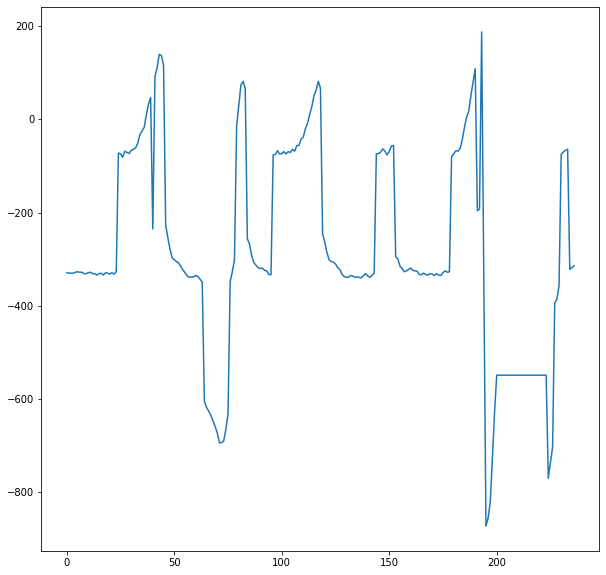

In [8]:
plt.figure(figsize=(10,10))
plt.plot(np.array(pos_hist)*-1)